In [1]:
from __future__ import print_function
from __future__ import division

In [2]:
%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
# better-looking plots
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (10.0, 8)
plt.rcParams['font.size'] = 18
mpl.ticker.AutoLocator.default_params['nbins'] = 5
mpl.ticker.AutoLocator.default_params['prune'] = 'both'

In [3]:
import numpy as np
from astropy.io import fits
from astropy.table import Table
from scipy.stats import binned_statistic, scoreatpercentile
import pickle

In [86]:
import params

source_directory = params.source_directory
save_directory = params.numpy_save_directory
full_sample = params.full_sample
volume_limited_sample = params.volume_limited_sample
question = params.question
question_dictionary = params.question_dictionary
bins_to_plot = params.bins_to_plot
print('Question to be debiased: {}'.format(question))

min_log_fv = -1.5#np.log10(0.1)
max_log_fv = 0.1 #np.log10(0.9)

min_log_fv = np.log10(0.1)
max_log_fv = np.log10(0.8)

Question to be debiased: t01_smooth_or_features


In [5]:
all_data = fits.getdata(source_directory + full_sample,1)
vl_data = fits.getdata(source_directory + volume_limited_sample,1)
all_data = Table(all_data)
vl_data = Table(vl_data)
print('Loaded galaxy data...')

with open(source_directory+question_dictionary, 'rb') as h:
    questions = pickle.load(h)
print('Loaded question dictionary...')
# Stuff obtained from the voronoi code:
all_voronoi = fits.getdata(save_directory+'bins.fits',1)
all_voronoi = Table(all_voronoi)
vbins_table = fits.getdata(save_directory+'vbins_table.fits',1)
vbins_table = Table(vbins_table)
print('Loaded voronoi bins...')

Loaded galaxy data...
Loaded question dictionary...
Loaded voronoi bins...


In [50]:
# Make a table for writing in data if none already exist:
if os.path.isfile(save_directory+'full_sample_debiased.fits') is True:
    all_data_save = fits.getdata(save_directory+'full_sample_debiased.fits',1)
    all_data_save = Table(all_data_save)
else:
    all_data_save = Table()
    
if os.path.isfile(save_directory+'vl_sample_debiased.fits') is True:
    vl_data_save = fits.getdata(save_directory+'vl_sample_debiased.fits',1)
    vl_data_save = Table(all_data_save)
else:
    vl_data_save = Table()

In [7]:
def make_figure_directory(name):
    full_name = 'figures/' + question + '/' + name + '/'
    if os.path.isdir(full_name) is False:
        os.mkdir(full_name)
        print('Made directory:' + full_name)
    return None

os.mkdir('figures/' + question + '/') if os.path.isdir('figures/' + question + '/') is False else None
for name in ['fitted_results','fit_setups','kc_fitted_functions','debiased_plots']:
    make_figure_directory(name)

In [8]:
## from 01_select.py

def select_data_arm_number(data,debiased,question,questions,N_cut=5,p_cut=0.5):
    
    pre_questions = questions[question]['pre_questions']
    pre_answers = questions[question]['pre_answers']
    
    strings = [pre_questions[s] + '_' + pre_answers[s] for s in range(len(pre_answers))]
    p_strings = [s + '_debiased' for s in strings]
    N_string = strings[-1] + '_count'

    p_values = np.ones(len(data))
    N_values = np.ones(len(data))

    for Q in p_strings:
        p_values = p_values*debiased[Q]
    N_values = N_values*data[N_string]

    select = (p_values > p_cut) & (N_values >= N_cut)
    
    print('{}/{} ({}%) galaxies selected in sample with p>{}and N>={}.'.format(np.sum(select),len(select),
                                                                               100*np.sum(select)/len(select),p_cut,N_cut))
    
    return select

In [9]:
## from 11_voronoi_assignment.py

def redshift_binning(data,voronoi_bins,question,questions,min_gals=50):
    
    answers = questions[question]['answers']
    morph_fv_cols = ['{}_{}_weighted_fraction'.format(question, a) 
                     for a in answers]
    redshift = data['REDSHIFT_1']
    z_bins = np.zeros((len(morph_fv_cols), len(data)), np.int)

    for N in np.unique(voronoi_bins):
        inbin = voronoi_bins == N

        for m, fv_col in enumerate(morph_fv_cols):
            # Select bins such that >= min_gals objects
            # with at least one vote are in each bin
            has_morph = data[fv_col][inbin] > 0
            n_with_morph = (has_morph).sum()
            n_zbins = n_with_morph / min_gals 
            n_zbins = max(n_zbins, 5)
            z = redshift[inbin]
            z_with_morph = z[has_morph]
            z_with_morph.sort()
            bin_edges = np.linspace(0, len(z_with_morph)-1, n_zbins+1, dtype=np.int)
            z_edges = z_with_morph[bin_edges]
            z_edges[0] = 0
            z_edges[-1] = 1
            z_bins[m, inbin] = np.digitize(z, z_edges)

    return z_bins

In [10]:
def save_bin_assignments(v_bins, z_bins, question='t11_arms_number'):
    assignments = Table(data=[v_bins], names=['vbin'])
    for m in range(len(z_bins)):
        zcol = 'zbin_{}'.format(m)
        assignments[zcol] = z_bins[m]
    assignments.write(save_directory + 'bin_assignments_{}.fits'.format(question),
                      overwrite=True)
    return assignments

In [11]:
if questions[question]['pre_questions'] != None:
    select = select_data_arm_number(all_data,question,questions)
    data = all_data[select]
    voronoi = all_voronoi[select]

else:
    data = all_data
    voronoi = all_voronoi
    print('Primary question, so all {} galaxies used for debiasing.'.format(len(data)))

Primary question, so all 248883 galaxies used for debiasing.


In [12]:
redshift_bins = redshift_binning(data, voronoi['voronoi_bin'],question,questions)
bin_assignments = save_bin_assignments(voronoi['voronoi_bin'],redshift_bins,question)

In [13]:
def f_logistic(x, k, c):
    # Function to fit the data bin output from the raw plot function
    L = 1 + np.exp(c)
    r = L / (1.0 + np.exp(-k * x + c))
    return r


def f_exp(x, k):
    # Function to fit the data bin output from the raw plot function
    r = np.exp(k * x)
    return r


def f_exp_pow(x, k, c):
    # Function to fit the data bin output from the raw plot function
    r = np.exp(-k * (-x) ** c)
    return r


def chisq_fun(p, f, x, y):
    return ((f(x, *p) - y)**2).sum()

In [14]:
def i_f_logistic(y, k, c):
    # inverse of f_logistic
    L = 1 + np.exp(c)
    x = -(np.log(L / y - 1) - c) / k
    return x

def i_f_exp_pow(y, k, c):
    # inverse of f_exp_pow
    ok = k > 0
    x = np.zeros_like(y) - np.inf
    x[ok] = -(-np.log(y[ok]) /k[ok] )**(1.0/c[ok])
    return x

def inverse_f(f):
    if f == f_logistic:
        return i_f_logistic
    elif f == f_exp_pow:
        return i_f_exp_pow

In [15]:
def plot_raw(ax, D, color):
    # Plot cumulative fractions for the raw data
    ax.plot(D['log10fv'], D['cumfrac'], '-', color=color, lw=2, alpha=0.2)


def plot_function(ax, f, x, p, color, style='--'):
    # Plot fitted function to cumulative fractions
    ax.plot(x, f(x, *p), style, color=color, lw=0.5)


def plot_guides(ax):
    # Plot guides at 20%, 50%, 80%
    x_guides = np.log10([0.2, 0.5, 0.8])
    y_guides = np.array([0, 1.05])
    for xg in x_guides:
        ax.plot([xg, xg], y_guides, color=[0, 0, 0], alpha=0.3)

        
def plot_limits(x, p=1, d=0.05):
    low, high = scoreatpercentile(x, (p, 100-p))
    diff = high-low
    low -= d * diff
    high += d * diff
    return low, high


def finish_vbin_plot(fig, ax, answerlabels, m, v):
    plot_guides(ax)
    ax.tick_params(axis='both', labelsize=10)
    ax.set_xticks(np.arange(-1.5, 0.1, 0.5))
    ax.text(-1.9, 0.95, answerlabels[m],
            fontsize=10, ha='left')
    ax.set_ylim([0, 1.05])
    if m > 2:
        ax.set_xlabel(r'$\log(v_f)$')
    if m in (0, 3):
        ax.set_ylabel('Cumulative fraction')
    if m == 1:
        ax.set_title('Voronoi bin %02i' % v)
    fig.subplots_adjust(wspace=0, hspace=0)

In [16]:
from scipy.optimize import minimize

def fit_vbin_function(data, bin_assignments, fit_setup,
                      question,questions,kc_fit_results=None,
                      plot=bins_to_plot,min_log_fv=min_log_fv):
    # Output fitted function for each of the Voronoi bins,
    # arm numbers and redshift bins.
    
    answers = questions[question]['answers']
    answerlabels = questions[question]['answerlabels']

    morph_fv_cols = ['{}_{}_weighted_fraction'.format(question, a) 
                     for a in answers]
    redshift = data['REDSHIFT_1']
    vbins = bin_assignments['vbin']

    if kc_fit_results is not None:
        kcfunc, kparams, cparams, kclabel = kc_fit_results
    
    # Set up the list to write the parameters in to:
    param_data = []
    
    max_z_bins_to_plot = 5
    
    # Loop over Voronoi magnitude-size bins
    for v in np.unique(vbins):
        vselect = vbins == v
        data_v = data[vselect]
        bin_assignments_v = bin_assignments[vselect]

        if v in plot:
            fig,axarr = make_axes(n_morph=len(answers))
            x = np.linspace(-2,0,1000)

        # Loop over morphological categories
        for m, fv in enumerate(morph_fv_cols):
            z_bins = bin_assignments_v['zbin_{}'.format(m)]
            z_bins_unique = np.unique(z_bins)
            n_z_bins = len(z_bins_unique)
            z_bins_to_plot = z_bins_unique[::(n_z_bins // max_z_bins_to_plot) + 1]
            z_min = z_bins.min()
            z_max = z_bins.max()
            clr_diff = (1.0 / (z_max - z_min)) if z_max - z_min != 0 else 0

            # Loop over redshift slices
            for z in z_bins_unique:
                data_z = data_v[z_bins == z]
                n = len(data_z)
                clr_z = [min((z - 1) * clr_diff, 1), 0,
                         max(1 - (z - 1) * clr_diff, 0)]

                # Compute cumulative fraction
                D = data_z[[fv]]
                D.sort(fv)
                D['cumfrac'] = np.linspace(0, 1, n)
                #D = D[D[fv] > min_fv]
                D['log10fv'] = np.log10(D[fv])
                D = D[D['log10fv'] > min_log_fv]

                # Fit function to the cumulative fraction
                # Start fits off in roughly right place with sensible bounds
                func, p0, bounds = get_fit_setup(fit_setup, m)
                # Note that need to cast x and y to float64 in order
                # for minimisation to work correctly
                res = minimize(chisq_fun, p0,
                               args=(func,
                                     D['log10fv'].astype(np.float64),
                                     D['cumfrac'].astype(np.float64)),
                               bounds=bounds, method='SLSQP')
                p = res.x
                chi2nu = res.fun / (n - len(p))
                
                means = [data_z['PETROMAG_MR'].mean(),
                         np.log10(data_z['PETROR50_R_KPC']).mean(),
                         data_z['REDSHIFT_1'].mean()]
                                
                if v in plot and z in z_bins_to_plot:
                    ax = axarr[m]
                    plot_raw(ax, D, clr_z)
                    plot_function(ax, func, x, p, clr_z)
                    if kc_fit_results is not None:
                        kf = kcfunc(means, *kparams[m])
                        cf = kcfunc(means, *cparams[m])
                        plot_function(ax, func, x, (kf, cf), clr_z, style=':')

                if len(p) < 2:
                    p = np.array([p[0], 10])

                param_data.append([v, m, z] + means + p[:2].tolist() +
                                  [chi2nu])

            if v in plot:
                finish_vbin_plot(fig, ax, answerlabels, m, v)
        if v in plot:
            
            suffix = '_kcfit{}'.format(kclabel) if kc_fit_results is not None else ''
            fig.savefig('figures/' + question + '/fitted_results/fit_{}_vbin{:02d}{}.pdf'.format(question, v, suffix),
                        dpi=100)
            plt.close()

    fit_vbin_results = Table(rows=param_data,
                             names=('vbin', 'answer', 'zbin', 'Mr',
                                    'R50', 'redshift', 'k', 'c', 'chi2nu'))
    fit_vbin_results.write(save_directory + 'fit_vbin_results_{}.fits'.format(question),
                           overwrite=True)
    return fit_vbin_results

In [17]:
def get_fit_setup(fit_setup, m):
    def get_m(x):
        return x[m] if m in x.keys() else x[None]
    func = get_m(fit_setup['func'])
    p0 = get_m(fit_setup['p0'])
    bounds = get_m(fit_setup['bounds'])
    return func, p0, bounds

In [18]:
def make_axes(n_morph,xlabel='$\log(f_v)$',ylabel='cumulative fraction'):

    x_dimension = math.ceil(math.sqrt(n_morph))
    y_dimension = math.ceil(n_morph/x_dimension)
    n_plots = x_dimension*y_dimension
    n_spare = n_plots-n_morph
    remove_axes = np.arange(-n_spare,0)
    fig,axes = plt.subplots(y_dimension,x_dimension,sharex=True,sharey=True,figsize=(5*x_dimension,5*y_dimension))
    for ax in axes[-1,:]:
        ax.set_xlabel(xlabel)
    for ax in axes[:,0]:
        ax.set_ylabel(ylabel) 
    plt.subplots_adjust(hspace=0,wspace=0)
    axes=axes.ravel()
    for m in remove_axes:
        fig.delaxes(axes[m])
    return fig,axes

Exponential function chosen for a01_smooth
Logistic function chosen for a02_features_or_disk
Logistic function chosen for a03_star_or_artifact


/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:18: RuntimeWarning: divide by zero encountered in log10


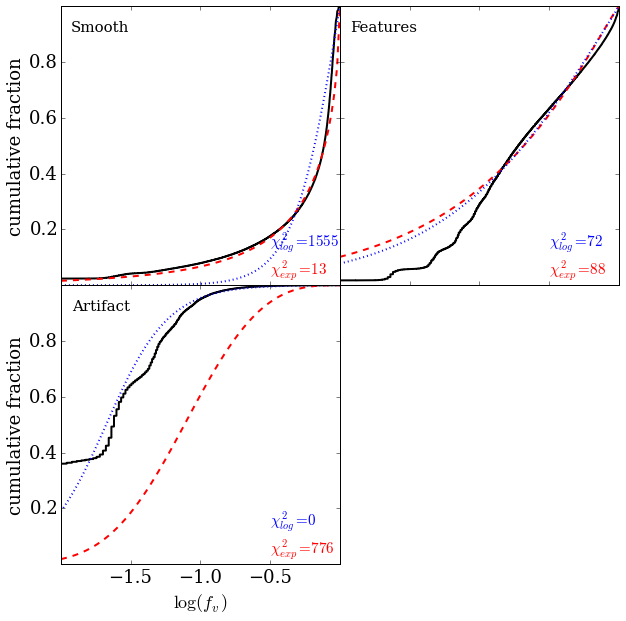

In [87]:
# Choose the best fit setup for arm number:

def make_setup_dictionary(question,questions,plot=True,min_log_fv=min_log_fv,max_log_fv=max_log_fv):

    fit_setup = {}
    fit_setup['func'] = {None: f_logistic}
    fit_setup['bounds'] = {None: params.logistic_bounds}
    fit_setup['p0'] = {None:[3,-3]}

    n_morph = len(questions[question]['answers'])
    fig,axes = make_axes(n_morph)

    fractions = [question + '_' + s + '_weighted_fraction' for s in questions[question]['answers']]
    counts = [question + '_' + s + '_count' for s in questions[question]['answers']]

    for m in range(n_morph):
    
        p_values = np.log10(np.sort(data[fractions[m]]))
        n = len(p_values)
        cumfrac = np.linspace(0,1,n)
        D = Table(np.array([cumfrac,p_values]).T,names=('cumfrac','log10fv'))
        D_fit = D[(D['log10fv'] > min_log_fv) & (D['log10fv'] < max_log_fv)] # usually see a 'levelling off' ath the
    # low end, so don't fit this.
    
        axes[m].plot(D['log10fv'],D['cumfrac'],'k-',linewidth=2)
    
        res_log = minimize(chisq_fun,x0=[3,-3],
                           args=(f_logistic,
                                 D_fit['log10fv'].astype(np.float64),
                                 D_fit['cumfrac'].astype(np.float64)),
                                 method='SLSQP',bounds=params.logistic_bounds)
    
        res_exp = minimize(chisq_fun,x0=[2,1],
                           args=(f_exp_pow,
                                 D_fit['log10fv'].astype(np.float64),
                                 D_fit['cumfrac'].astype(np.float64)),
                                 method='SLSQP',bounds=params.exponential_bounds)
                    
        xg = np.linspace(-2,0,100)
    
        axes[m].plot(xg,f_exp_pow(xg,res_exp.x[0],res_exp.x[1]),'r--',linewidth=2)
        axes[m].plot(xg,f_logistic(xg,res_log.x[0],res_log.x[1]),'b:',linewidth=2)
    
        chisq_exp = chisq_fun(res_exp.x,f_exp_pow,D_fit['log10fv'],D_fit['cumfrac'])
        chisq_log = chisq_fun(res_log.x,f_logistic,D_fit['log10fv'],D_fit['cumfrac'])
        if chisq_exp < chisq_log:
            f = f_exp_pow
            bounds = params.exponential_bounds
            res = res_exp.x
            print('Exponential function chosen for ' + questions[question]['answers'][m])
        else:
            f = f_logistic
            bounds = params.logistic_bounds
            res = res_log.x
            print('Logistic function chosen for ' + questions[question]['answers'][m])
    
        fit_setup['func'].update({m:f})
        fit_setup['bounds'].update({m:bounds})
        fit_setup['p0'].update({m:res})
    
        axes[m].text(0.75,0.2,r'$\chi^{2}_{log}' + '={0:.0f}$'.format(chisq_log)
                     ,family='serif',horizontalalignment='left',verticalalignment='top'
                     ,transform = axes[m].transAxes,size=15,color='blue')
        axes[m].text(0.75,0.1,r'$\chi^{2}_{exp}' + '={0:.0f}$'.format(chisq_exp)
                     ,family='serif',horizontalalignment='left',verticalalignment='top'
                     ,transform = axes[m].transAxes,size=15,color='red')
        
        axes[m].text(0.04,0.95,questions[question]['answerlabels'][m]
                     ,family='serif',horizontalalignment='left',verticalalignment='top'
                     ,transform = axes[m].transAxes,size=15)
    
    plt.xlim(-2,0)
    plt.ylim(0,1)
    
    if plot == True:
        plt.savefig('figures/' + question + '/fit_setups/' + question + '_setup.pdf')
        
    return fit_setup

fit_setup = make_setup_dictionary(question,questions)

In [36]:
fit_vbin_results = fit_vbin_function(data, bin_assignments, fit_setup,
                                     question,questions)
# This part takes the longest (fitting curves to the data)

/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:57: RuntimeWarning: divide by zero encountered in log10


In [37]:
def plot_fit_vbin(question,questions,parameter='k', predictor=None):
    
    answerlabels = questions[question]['answerlabels']
    
    n_morph = len(questions[question]['answers'])
    fig, axarr = plt.subplots(n_morph, 3, sharey='row', sharex='col', figsize=(15,3*n_morph))
    def plot(ax, x, answer, colourby):
        r = fit_vbin_results[fit_vbin_results['answer'] == answer]
        if predictor is None:
            param = r[parameter]
        else:
            f, p = predictor
            var = np.array([r[c] for c in ['Mr', 'R50', 'redshift']], np.float64)
            if p is not None:
                param = f(var, *p[answer])
            else:
                param = f(var)
        ax.scatter(r[x], param, c=r[colourby], marker='.', edgecolor='')
        y, bin_edges, binnumber = binned_statistic(r[x], r[parameter], statistic='median')
        xc = 0.5 * (bin_edges[:-1] + bin_edges[1:])
        ax.plot(xc, y, 'k-')
        if predictor is not None:
            y, bin_edges, binnumber = binned_statistic(r[x], param, statistic='median')
            xc = 0.5 * (bin_edges[:-1] + bin_edges[1:])
            ax.plot(xc, y, 'k--')
        low, high = plot_limits(r[parameter])
        ax.axis(ymin=low, ymax=high)
    for a, axrow in enumerate(axarr):
        plot(axrow[0], 'redshift', a, 'vbin')
        plot(axrow[1], 'R50', a, 'redshift')
        plot(axrow[2], 'Mr', a, 'redshift')
        axrow[0].set_ylabel("${}$ ({})".format(parameter,answerlabels[a]))
        if a == len(axarr) - 1:
            axrow[0].set_xlabel('$z$')
            axrow[1].set_xlabel('$\log_{10}{R_{50}}$')
            axrow[2].set_xlabel('$M_r$')
    fig.subplots_adjust(hspace=0, wspace=0)

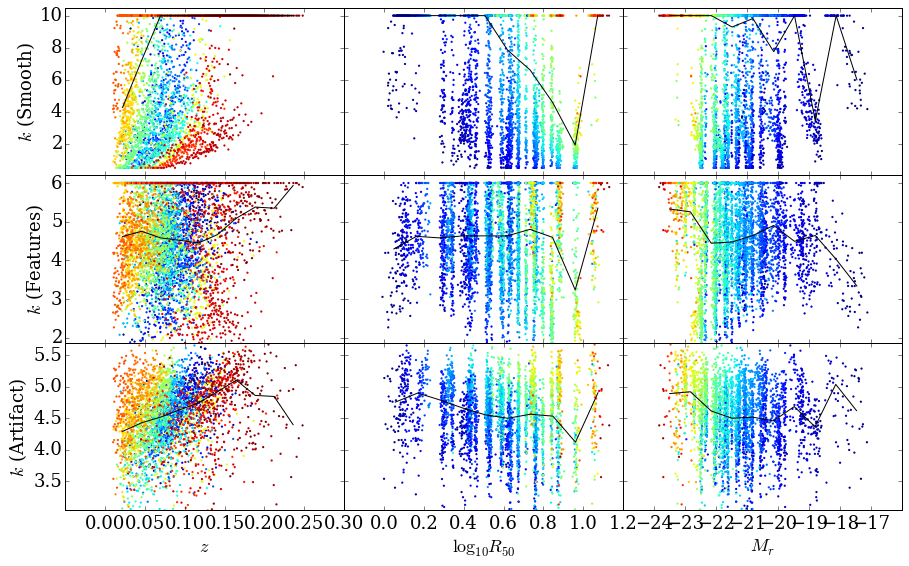

In [38]:
plot_fit_vbin(question,questions,'k')
plt.savefig('figures/' + question + '/kc_fitted_functions/{}_k_x.pdf'.format(question))

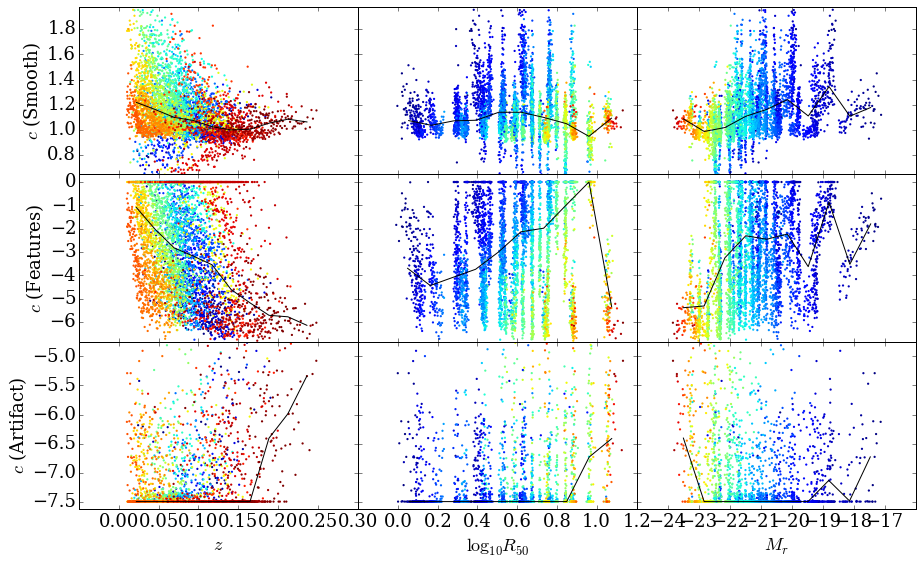

In [39]:
plot_fit_vbin(question,questions,'c')
plt.savefig('figures/' + question +'/kc_fitted_functions/{}_c_x.pdf')

In [40]:
from scipy.optimize import curve_fit

def kcfunc(x, A0, AM, AR, Az):
    # linear combination of (magnitude, size, redshift) + an offset
    r = A0 + AM*x[0] + AR*x[1] + Az*x[2]    
    return r


def fit_mrz(d, f=kcfunc):
    # Fit a linear function of M, R and z to k and c

    answers = d['answer']
    answer_list = np.unique(answers)
    n_answers = len(answer_list)
    
    dout = d.copy()
    dout['kf'] = np.zeros(len(d))
    dout['cf'] = np.zeros(len(d))
    
    kparams = []
    cparams = []
    
    kmin = [d[answers == a]['k'].min() for a in answer_list]
    kmax = [d[answers == a]['k'].max() for a in answer_list] 
    cmin = [d[answers == a]['c'].min() for a in answer_list]
    cmax = [d[answers == a]['c'].max() for a in answer_list] 

    # Loop over GZ morphologies
    for a in answer_list:
        select = answers == a
        da = d[select]
        x = np.array([da[c] for c in ['Mr', 'R50', 'redshift']], np.float64)
        k = da['k'].astype(np.float64)
        c = da['c'].astype(np.float64)

        kp, kc = curve_fit(f, x, k, maxfev=1000)
        cp, cc = curve_fit(f, x, c, maxfev=1000)
        
        dout['kf'][select] = f(x, *kp)
        dout['cf'][select] = f(x, *cp)

        kparams.append(kp)
        cparams.append(cp)

    return kparams, cparams, dout, kmin, kmax, cmin, cmax

In [41]:
kparams, cparams, dout, kmin, kmax, cmin, cmax = fit_mrz(fit_vbin_results, kcfunc)

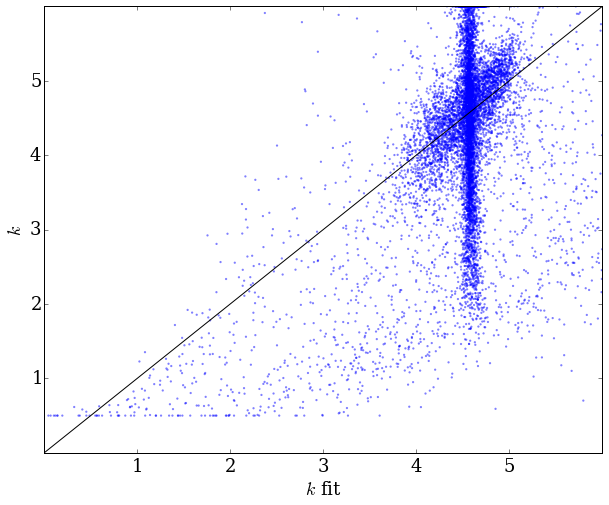

In [42]:
plt.scatter(dout['kf'], dout['k'], c='b',
            marker='.', edgecolor='', alpha=0.5)
#plt.scatter(dout2['kf'], dout['k'], c='b',
            #marker='.', edgecolor='', alpha=0.5)
plt.plot([0, 6], [0, 6], 'k-')
plt.xlabel('$k$ fit')
plt.ylabel('$k$')
_ = plt.axis((0, 6, 0, 6))

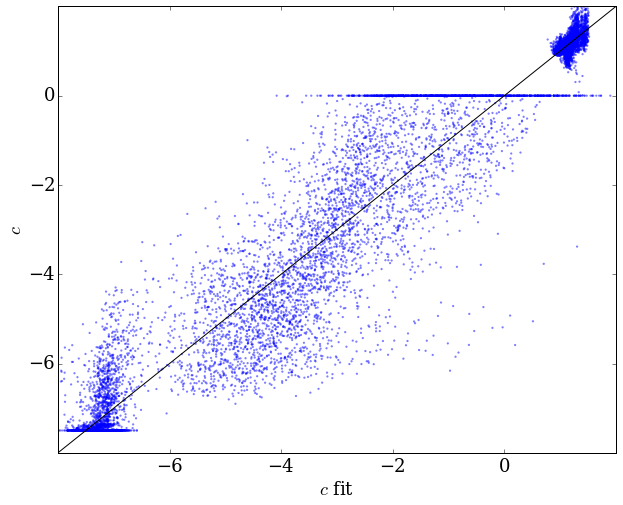

In [43]:
plt.scatter(dout['cf'], dout['c'], c='b',
            marker='.', edgecolor='', alpha=0.5)
#plt.scatter(dout2['cf'], dout['c'], c='b',
            #marker='.', edgecolor='', alpha=0.5)
plt.plot([-8, 2], [-8, 2], 'k-')
plt.xlabel('$c$ fit')
plt.ylabel('$c$')
_ = plt.axis((-8, 2, -8, 2))

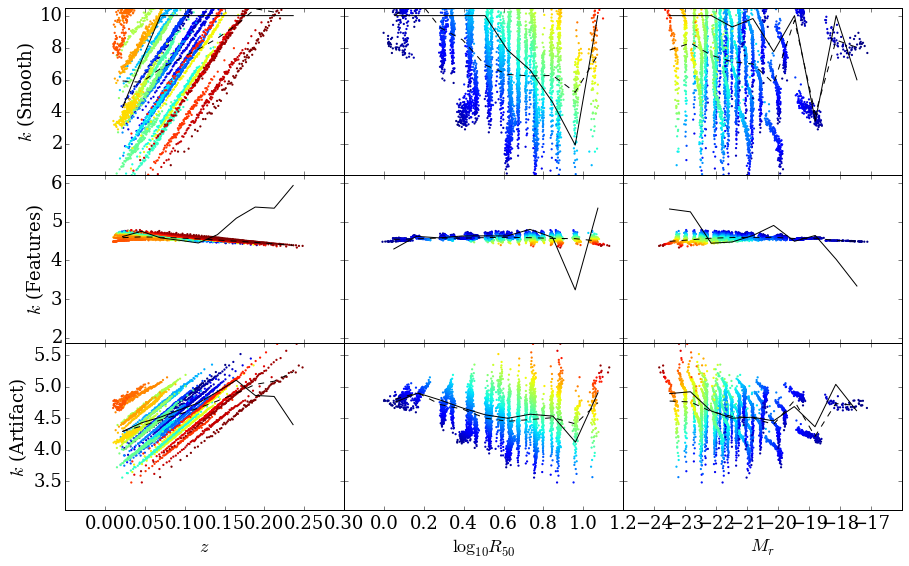

In [44]:
plot_fit_vbin(question,questions,'k', predictor=(kcfunc, kparams))
plt.savefig('figures/' + question + '/kc_fitted_functions/{}_k_x_fit1.pdf'.format(question))

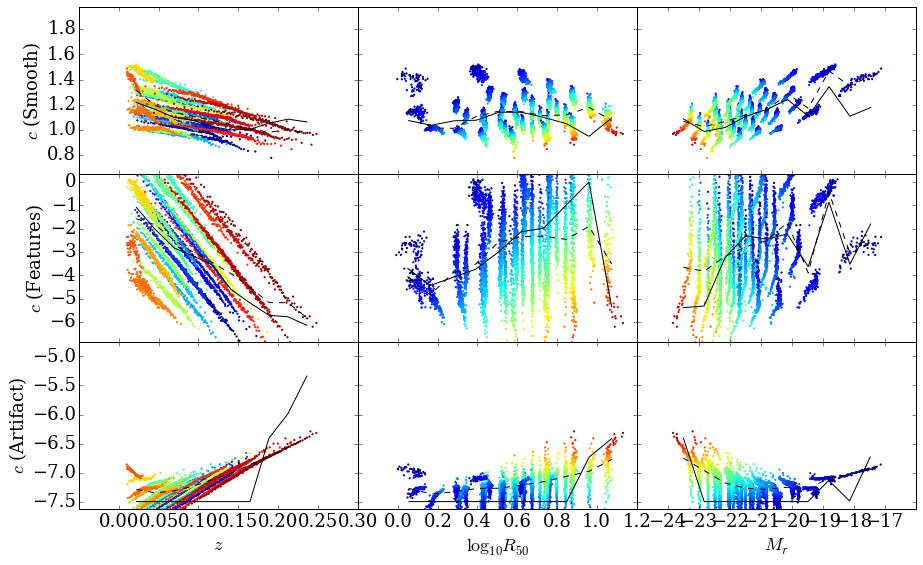

In [45]:
plot_fit_vbin(question,questions,'c', predictor=(kcfunc, cparams))
plt.savefig('figures/' + question + '/kc_fitted_functions/{}_c_x_fit1.pdf'.format(question))

In [88]:
# plot cumulative histograms with adopted fit
fit_vbin_results = fit_vbin_function(data, bin_assignments, fit_setup,
                                     question,questions,kc_fit_results=(kcfunc, kparams, cparams, 1))

/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:57: RuntimeWarning: divide by zero encountered in log10


KeyboardInterrupt: 

In [92]:
def debias(data, z_base, kcfunc, kparams, cparams,
           question,questions):
    # Debias the dataset
    answers = questions[question]['answers']
    
    morph_fv_cols = ['{}_{}_weighted_fraction'.format(question, a) 
                     for a in answers]
    
    debiased = data[morph_fv_cols]

    # Each galaxy gets a function fit to its M,R and z parameters, which are scaled
    # to the equivalent M and r functions at low z.

    for m, fv_col in enumerate(morph_fv_cols):
        fv = debiased[fv_col]
        fv_nonzero = fv > 0
        log10fv = np.log10(np.asarray(fv[fv_nonzero]))
        
        func, _, _ = get_fit_setup(fit_setup, m)
        ifunc = inverse_f(func)
        d = data[fv_nonzero]
        x = np.array([d['PETROMAG_MR'],
                      np.log10(d['PETROR50_R_KPC']),
                      d['REDSHIFT_1']], np.float64)
        k = kcfunc(x, *kparams[m])
        c = kcfunc(x, *cparams[m])

         #create version of x with all redshifts at z_base
        xb = x.copy()
        xb[-1] = z_base
        
        kb = kcfunc(xb, *kparams[m])
        cb = kcfunc(xb, *cparams[m])

         #possibly deal with any functions outside the k and c limits here
        cumfrac = func(log10fv, k, c)
        log10fv_debiased = ifunc(cumfrac, kb, cb)
        fv_debiased = 10**(log10fv_debiased)

        debiased[fv_col][fv_nonzero] = fv_debiased

    return debiased 

In [93]:
# Do the debiasing of the FULL sample...

z_base = 0.03
    
def debias_fits(data,data_save):

    answers = questions[question]['answers']
    debiased = debias(data, z_base, kcfunc, kparams, cparams,
                  question,questions)
    
    for c in enumerate(debiased.colnames):
        fits_col = question + '_' + answers[c[0]] + '_debiased'
        data_save[fits_col] = debiased[c[1]]

    return debiased

debiased_full = debias_fits(all_data,all_data_save)
debiased = debias_fits(vl_data,vl_data_save)

/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in power


In [96]:
vl_data_save.write(save_directory+'vl_sample_debiased.fits',overwrite=True)
all_data_save.write(save_directory+'full_sample_debiased.fits',overwrite=True)

In [100]:
def plot_debiased(data, debiased,question,questions,subsample=10):
    # Plot debiased values vs. raw values for comparison. Blue -> red with z.
    answers = questions[question]['answers']
    answerlabels = questions[question]['answerlabels']
    
    data = data[::subsample]
    debiased = debiased[::subsample]
    
    morph_fv_cols = ['{}_{}_weighted_fraction'.format(question, a) 
                     for a in answers]

    fig, axarr = make_axes(n_morph=len(morph_fv_cols),xlabel='$f_{v,raw}$',ylabel='$f_{v,debiased}$')

    z = data['REDSHIFT_1']

    for m, fv_col in enumerate(morph_fv_cols):
        ax = axarr.ravel()[m]
        sc = ax.scatter(data[fv_col], debiased[fv_col],
                        marker=".", c=z, edgecolor='',
                        cmap=plt.cm.coolwarm,
                        norm=mpl.colors.LogNorm())

        ax.axis((0, 1, 0, 1))
        ax.plot([0,1],[0,1],"k-")

        ax.text(0.4, 0.9, answerlabels[m], fontsize='small', ha='left')

        if m > 2:
            ax.set_xlabel(r"$f_v$")
        if m == 0 or m == 3:
            ax.set_ylabel(r"$f_{v,\mathrm{debiased}}$")

    fig.subplots_adjust(hspace=0, wspace=0, right=0.85)

    cbar_ax = fig.add_axes([0.9, 0.25, 0.025, 0.5])
    cbar = fig.colorbar(sc, cax=cbar_ax, format='%.2f')
    cbar_ax.set_yticks([0.04,0.06,0.08])
    cbar.ax.set_ylabel('redshift')
    
    fig.savefig('figures/' + question +'/debiased_plots/debiased.pdf',dpi=100)

In [98]:
def plot_vf_histogram(debiased):
    # Plot histogram of sums of f_v.
    
    fv = np.array([debiased[c] for c in debiased.colnames], np.float)
    sums = np.sum(fv, axis=0)
    sums = sums[sums != 0]
    ax.hist(sums, bins=50, histtype='stepfilled', range=(0, 3))

    ax.set_xlabel(r"$\Sigma f_v$")
    ax.set_ylabel(r"$N_{gal}$")

    fig.savefig('figures/' + question + '/debiased_plots/vf_histogram.pdf')

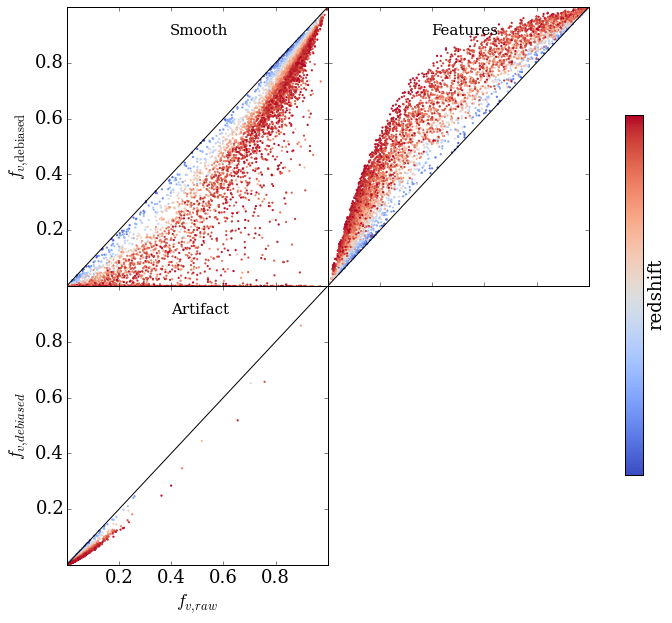

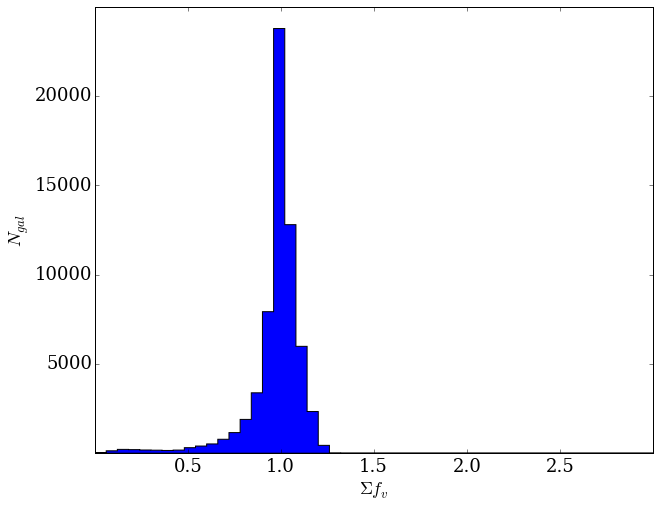

In [101]:
plot_debiased(vl_data,debiased,question,questions)
plot_vf_histogram(debiased)